## Training
Prepapre dataset with the prepare_dataset notebook, before running this one.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import scipy.io as sio
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")  # adds seaborn style to charts, eg. grid
plt.style.use("dark_background")  # inverts colors to dark theme
plt.rcParams['font.family'] = 'monospace'
import os
import warnings; warnings.filterwarnings("ignore")
from utils import calc_gso_batch # gso/pinn calculation
try: 
    JOBID = os.environ["SLURM_JOB_ID"] # get job id from slurm, when training on cluster
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # nvidia
    HAS_SCREEN = False # for plotting or saving images
except:
    device = torch.device("mps") # apple silicon
    JOBID = "local"
    HAS_SCREEN = True
os.makedirs(f"mg_data/{JOBID}", exist_ok=True)
print(f'device: {device}')

def to_tensor(x, device=torch.device("cpu")): return torch.tensor(x, dtype=torch.float32, device=device)

device: mps


# Best MSE loss: 0.087

In [2]:
SAVE_DIR = f"mg_data/{JOBID}" 
EPOCHS = 1000
BATCH_SIZE = 128
# LEARNING_RATE = 3e-4*np.linspace(1, 1e-2, EPOCHS)  # best
LEARNING_RATE = 3e-4*np.linspace(1, 1e-3, EPOCHS)  
# GSO_LOSS_RATIO = np.linspace(0.5, 0.1, EPOCHS) # best
GSO_LOSS_RATIO = np.linspace(0.4, 0.1, EPOCHS)
# GSO_LOSS_RATIO = (0.5+0.5*np.sin(np.linspace(0, 25*np.pi, EPOCHS)))#*np.linspace(1, 0.1, EPOCHS) # crazy
USE_CURRENTS = True
USE_PROFILES = True
USE_MAGNETIC = True
INPUT_SIZE = int(USE_CURRENTS)*14 + int(USE_PROFILES)*202 + int(USE_MAGNETIC)*187
TRAIN_DS_PATH = "data/train_ds.mat" # generated from prepapre_dataset
EVAL_DS_PATH = "data/eval_ds.mat"

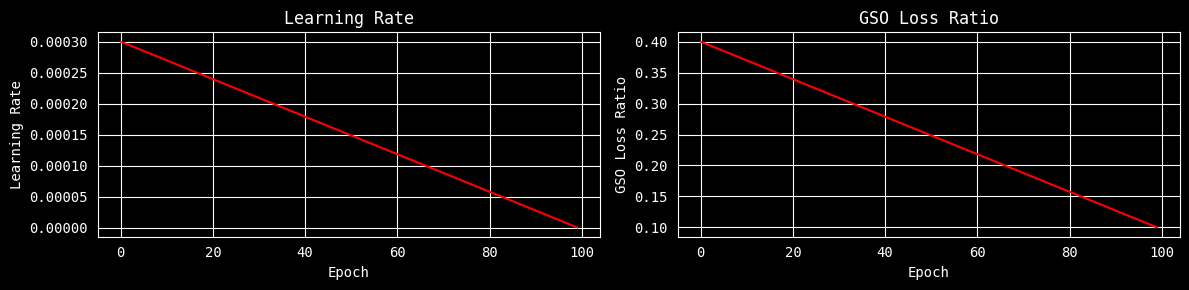

In [3]:
# plot schedulers: lr + gso loss ratio
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].set_title("Learning Rate")
ax[0].plot(LEARNING_RATE, color='red')
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Learning Rate")
ax[1].set_title("GSO Loss Ratio")
ax[1].plot(GSO_LOSS_RATIO, color='red')
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("GSO Loss Ratio")
plt.tight_layout()
plt.show() if HAS_SCREEN else plt.savefig(f"mg_data/{JOBID}/schedulers.png")

- mean current: -10183.76, std current: 34209.11
- mean magnetic: -0.20, std magnetic: 0.58
- mean f_profile: 33.13, std f_profile: 0.28
- mean p_profile: 9654.42, std p_profile: 8788.29

In [4]:
class PlaNetDataset(Dataset):
    def __init__(self, ds_mat_path):
        ds_mat = sio.loadmat(ds_mat_path)
        # output: magnetic flux, transposed (matlab is column-major)
        self.psi = to_tensor(ds_mat["psi"]).view(-1, 1, 64, 64)
        # inputs: radial and vertical position of pixels (for plotting only rn) + currents + measurements + profiles 
        self.rr = to_tensor(ds_mat["rr"]).view(-1,1,64,64) # radial position of pixels (64, 64)
        self.zz = to_tensor(ds_mat["zz"]).view(-1,1,64,64) # vertical position of pixels (64, 64)
        self.currs = ds_mat["currs"] # input currents (n, 14)
        self.magnetic = ds_mat["magnetic"] # input magnetic measurements (n, 187)
        self.f_profile = ds_mat["f_profiles"] # input profiles (n, 101)
        self.p_profile = ds_mat["p_profiles"] # input profiles (n, 101)
        inputs = [] # add the normalized inputs to the list
        if USE_CURRENTS: inputs.append((to_tensor(self.currs)+10183)/34209) # (n, 14) # normalized
        # if USE_CURRENTS: inputs.append((to_tensor(self.currs))) # (n, 14)
        if USE_MAGNETIC: inputs.append((to_tensor(self.magnetic)+0.2)/0.58) # (n, 187) # normalized
        # if USE_MAGNETIC: inputs.append((to_tensor(self.magnetic))) # (n, 187)
        if USE_PROFILES: inputs.append(torch.cat(((to_tensor(self.f_profile)-33.13)/0.28, (to_tensor(self.p_profile)-9654)/8788), 1)) # (n, 202) # normalized
        # if USE_PROFILES: inputs.append(torch.cat((to_tensor(self.f_profile), to_tensor(self.p_profile)), 1)) # (n, 202)
        self.inputs = torch.cat(inputs, 1) # (n, 403)
        #move to device (doable bc the dataset is fairly small, check memory usage)
        self.psi, self.inputs, self.rr, self.zz = self.psi.to(device), self.inputs.to(device), self.rr.to(device), self.zz.to(device)
        total_memory = sum([x.element_size()*x.nelement() for x in [self.psi, self.inputs, self.rr, self.zz]])
        print(f"Dataset: {len(self)}, memory: {total_memory/1024**2:.2f} MB")
    def __len__(self): return len(self.psi)
    def __getitem__(self, idx): return self.inputs[idx], self.psi[idx], self.rr[idx], self.zz[idx]

Dataset: 100, memory: 4.84 MB
Dataset length: 100
Input shape: torch.Size([403])
Output shape: torch.Size([1, 64, 64])
100


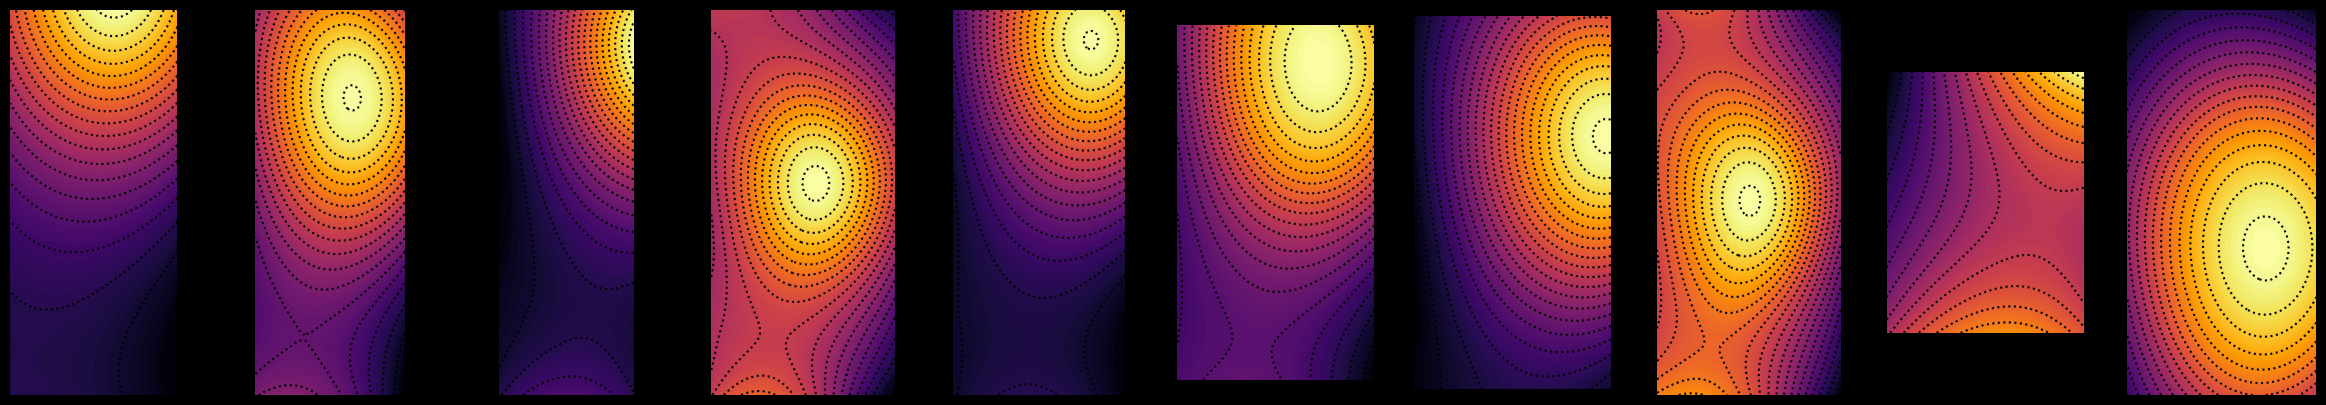

In [5]:
# test dataset
ds = PlaNetDataset(EVAL_DS_PATH)
print(f"Dataset length: {len(ds)}")
print(f"Input shape: {ds[0][0].shape}")
print(f"Output shape: {ds[0][1].shape}")
n_plot = 10
print(len(ds))
fig, axs = plt.subplots(1, n_plot, figsize=(3*n_plot, 5))
for i, j in enumerate(np.random.randint(0, len(ds), n_plot)):
    psi, rr, zz = ds[j][1].cpu().numpy().squeeze(), ds[j][2].cpu().numpy().squeeze(), ds[j][3].cpu().numpy().squeeze()
    axs[i].contourf(rr, zz, psi, 100, cmap="inferno")
    axs[i].contour(rr, zz, -psi, 20, colors="black", linestyles="dotted")
    axs[i].axis("off")
    axs[i].set_aspect("equal")
plt.show() if HAS_SCREEN else plt.savefig(f"mg_data/{JOBID}/dataset.png")

In [6]:
# MODEL: PlaNet: # Paper net: branch + trunk conenction and everything
from torch.nn import Module, Linear, Conv2d, MaxPool2d, BatchNorm2d, ReLU, Sequential, Upsample, ConvTranspose2d
class PlaNet(Module): # Paper net: branch + trunk conenction and everything
    from torch.nn import Linear, Conv2d, MaxPool2d, BatchNorm2d, ReLU
    def __init__(self):
        super(PlaNet, self).__init__()
        af = ReLU() # activation function
        #branch
        self.branch = Sequential(
            Linear(INPUT_SIZE, 256), af,
            Linear(256, 128), af,
            Linear(128, 64), af
        )
        #trunk
        # def trunk_block(): # faster
        #     return  Sequential(
        #         Conv2d(1, 8, kernel_size=3, stride=2, padding=1), BatchNorm2d(8), af,
        #         Conv2d(8, 16, kernel_size=3, stride=2, padding=1), BatchNorm2d(16), af,
        #         Conv2d(16, 32, kernel_size=3, stride=2, padding=1), BatchNorm2d(32), af,
        #     )
        def trunk_block(): 
            return  Sequential(
                Conv2d(1, 8, kernel_size=3, stride=1, padding=1), BatchNorm2d(8), af, MaxPool2d(2),
                Conv2d(8, 16, kernel_size=3, stride=1, padding=1), BatchNorm2d(16), af, MaxPool2d(2),
                Conv2d(16, 32, kernel_size=3, stride=1, padding=1), BatchNorm2d(32), af, MaxPool2d(2),
            )
        self.trunk_r, self.trunk_z = trunk_block(), trunk_block()
        self.trunk_fc = Sequential(
            Linear(2*32*8*8, 128), af,
            Linear(128, 64), af,
            Linear(64, 64), af,
        )
        # head
        self.fc = Sequential(Linear(64, 2048), af)
        self.anti_conv = Sequential( # U-Net style
            ConvTranspose2d(32, 32, kernel_size=2, stride=2), 
            Conv2d(32, 32, kernel_size=3, padding=0), af,
            Conv2d(32, 32, kernel_size=3, padding=0), af,
            ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            Conv2d(16, 16, kernel_size=3, padding=0), af,
            Conv2d(16, 16, kernel_size=3, padding=0), af,
            ConvTranspose2d(16, 8, kernel_size=2, stride=2),
            Conv2d(8, 8, kernel_size=3, padding=0), af,
            Conv2d(8, 8, kernel_size=3, padding=0), af,
            ConvTranspose2d(8, 4, kernel_size=2, stride=2),
            Conv2d(4, 2, kernel_size=3, padding=0), af,
            Conv2d(2, 1, kernel_size=3, padding=0), af,
            Conv2d(1, 1, kernel_size=5, padding=0),
        )
    def forward(self, x):
        xb, r, z = x
        #branch net
        xb = self.branch(xb)
        #trunk net
        r, z = self.trunk_r(r), self.trunk_z(z) # convolutions
        r, z = r.view(-1, 32*8*8), z.view(-1, 32*8*8) # flatten
        xt = torch.cat((r, z), 1) # concatenate
        xt = self.trunk_fc(xt) # fully connected
        # multiply trunk and branch
        x = xt * xb
        #head net
        x = self.fc(x)
        x = x.view(-1, 32, 8, 8)
        x = self.anti_conv(x)
        return x

In [7]:
x = (torch.rand(1, INPUT_SIZE), torch.rand(1, 1, 64, 64), torch.rand(1, 1, 64, 64))
net = PlaNet()
y = net(x)
print(f"in: {[x.shape for x in x]}, out: {y.shape}")
n_sampl = 7
nx = (torch.rand(n_sampl, INPUT_SIZE), torch.rand(n_sampl, 1, 64, 64), torch.rand(n_sampl, 1, 64, 64))
ny = net(nx)
print(f"in: {[x.shape for x in nx]}, out: {ny.shape}")
assert ny.shape == (n_sampl, 1, 64, 64), f"Wrong output shape: {ny.shape}"

in: [torch.Size([1, 403]), torch.Size([1, 1, 64, 64]), torch.Size([1, 1, 64, 64])], out: torch.Size([1, 1, 64, 64])
in: [torch.Size([7, 403]), torch.Size([7, 1, 64, 64]), torch.Size([7, 1, 64, 64])], out: torch.Size([7, 1, 64, 64])


## Training

In [ ]:
train_ds, val_ds = PlaNetDataset(TRAIN_DS_PATH), PlaNetDataset(EVAL_DS_PATH) # initialize datasets
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True) # initialize DataLoader
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)  
model = PlaNet()  # instantiate model
model.to(device) # move model to device
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE[0])
loss_fn = torch.nn.MSELoss() # Mean Squared Error Loss
tot_losses, mse_losses, gso_losses = [], [], [] # initialize losses
start_time = time() # start time
for ep in range(EPOCHS): 
    epoch_time = time()
    for pg in optimizer.param_groups: pg['lr'] = LEARNING_RATE[ep] # update learning rate
    model.train()
    trainloss, evalloss = [], []
    for input_currs, psi, rr, zz in train_dl:
        # input_currs, psi, rr, zz = input_currs.to(device), psi.to(device), rr.to(device), zz.to(device) # move to device
        optimizer.zero_grad() # zero gradients
        psi_pred = model((input_currs, rr, zz)) # forward pass
        gso, gso_pred = calc_gso_batch(psi, rr, zz, dev=device), calc_gso_batch(psi_pred, rr, zz, dev=device) # calculate grad shafranov
        mse_loss = loss_fn(psi_pred, psi) # mean squared error loss on psi
        gso_loss = loss_fn(gso_pred, gso) # PINN loss on grad shafranov
        loss = (1-GSO_LOSS_RATIO[ep])*mse_loss + GSO_LOSS_RATIO[ep]*gso_loss # total loss
        loss.backward() # backprop
        optimizer.step() # update weights
        trainloss.append((loss.item(), mse_loss.item(), gso_loss.item())) # save batch losses
    model.eval() # evaluation mode
    with torch.no_grad():
        for input_currs, psi, rr, zz in val_dl:
            # input_currs, psi, rr, zz = input_currs.to(device), psi.to(device), rr.to(device), zz.to(device) 
            psi_pred = model((input_currs, rr, zz))
            gso, gso_pred = calc_gso_batch(psi, rr, zz, dev=device), calc_gso_batch(psi_pred, rr, zz, dev=device)
            mse_loss = loss_fn(psi_pred, psi)
            gso_loss = loss_fn(gso_pred, gso)
            loss = (1-GSO_LOSS_RATIO[ep])*mse_loss + GSO_LOSS_RATIO[ep]*gso_loss # total loss
            evalloss.append((loss.item(), mse_loss.item(), gso_loss.item()))
    ttot_loss, tmse_loss, tgso_loss = map(lambda x: sum(x)/len(x), zip(*trainloss))
    etot_loss, emse_loss, egso_loss = map(lambda x: sum(x)/len(x), zip(*evalloss))
    # save model if improved        
    endp = "\n" 
    if etot_loss <= min(tot_losses, default=etot_loss): 
        torch.save(model.state_dict(), f"{SAVE_DIR}/mg_planet_tot.pth"); endp=" *tot\n"
    if emse_loss <= min(mse_losses, default=emse_loss):
        torch.save(model.state_dict(), f"{SAVE_DIR}/mg_planet_mse.pth"); endp=" *mse\n"
    if egso_loss <= min(gso_losses, default=egso_loss):
        torch.save(model.state_dict(), f"{SAVE_DIR}/mg_planet_gso.pth"); endp=" *gso\n"
    tot_losses.append(etot_loss); mse_losses.append(emse_loss); gso_losses.append(egso_loss) # save losses
    print(f"{ep+1}/{EPOCHS}: "
        #   f"Train: {ttot_loss:.4f}, mse {tmse_loss:.4f}, gso {tgso_loss:.4f} | " +
          f"Eval: tot {etot_loss:.4f}, mse {emse_loss:.4f}, gso {egso_loss:.4f} | " + 
          f"lr:{LEARNING_RATE[ep]:.1e}, r:{GSO_LOSS_RATIO[ep]:.2f} | {time()-epoch_time:.0f}s, eta:{(time()-start_time)*(EPOCHS-ep)/(ep+1)/60:.0f}m |", end=endp,  flush=True)
print(f"Training time: {(time()-start_time)/60:.0f}mins")
print(f"Best losses: tot {min(tot_losses):.3f}, mse {min(mse_losses):.3f}, gso {min(gso_losses):.3f}")
for l, n in zip([tot_losses, mse_losses, gso_losses], ["tot", "mse", "gso"]): np.save(f"{SAVE_DIR}/{n}_losses.npy", l) # save losses

Dataset: 400, memory: 19.36 MB
Dataset: 100, memory: 4.84 MB
1/100: Eval: tot 43.1331, mse 51.7769, gso 30.1675 | lr:3.0e-04, r:0.40 | 2s, eta:3m | *gso


In [ ]:
# plot losses
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
ax[0,0].set_title("TOT Loss")
ax[0,0].plot(tot_losses, color='red')
ax[0,0].set_xlabel("Epoch")
ax[0,0].set_ylabel("Loss")
ax[0,1].set_title("MSE Loss")
ax[0,1].plot(mse_losses, color='red')
ax[0,1].set_xlabel("Epoch")
ax[0,1].set_ylabel("Loss")
ax[0,2].set_title("GSO Loss")
ax[0,2].plot(gso_losses, color='red')
ax[0,2].set_xlabel("Epoch")
ax[0,2].set_ylabel("Loss")
#now the same but with log scale
ax[1,0].set_title("TOT Loss (log)")
ax[1,0].plot(tot_losses, color='red')
ax[1,0].set_xlabel("Epoch")
ax[1,0].set_ylabel("Loss")
ax[1,0].set_yscale("log")
ax[1,1].set_title("MSE Loss (log)")
ax[1,1].plot(mse_losses, color='red')
ax[1,1].set_xlabel("Epoch")
ax[1,1].set_ylabel("Loss")
ax[1,1].set_yscale("log")
ax[1,2].set_title("GSO Loss (log)")
ax[1,2].plot(gso_losses, color='red')
ax[1,2].set_xlabel("Epoch")
ax[1,2].set_ylabel("Loss")
ax[1,2].set_yscale("log")
plt.tight_layout()
plt.show() if HAS_SCREEN else plt.savefig(f"mg_data/{JOBID}/losses.png")

In [ ]:
# testing network output
for tit, best_model_path in zip(["TOT","MSE", "GSO"], ["mg_planet_tot.pth", "mg_planet_mse.pth", "mg_planet_gso.pth"]):
    model = PlaNet()
    model.load_state_dict(torch.load(f"{SAVE_DIR}/{best_model_path}"))
    model.eval()
    ds = PlaNetDataset(EVAL_DS_PATH)
    # ds = PlaNetDataset(TRAIN_DS_PATH)
    os.makedirs(f"mg_data/{JOBID}/imgs", exist_ok=True)
    N_PLOTS = 33
    for i in np.random.randint(0, len(ds), N_PLOTS):  
        fig, axs = plt.subplots(2, 5, figsize=(15, 9))
        input_currs, psi_ds, rr, zz = ds[i]
        input_currs, psi_ds, rr, zz = input_currs.to('cpu'), psi_ds.to('cpu'), rr.to('cpu'), zz.to('cpu')
        input_currs, psi_ds, rr, zz = input_currs.view(1,-1), psi_ds.view(1,1,64,64), rr.view(1,1,64,64), zz.view(1,1,64,64)
        psi_pred = model((input_currs, rr, zz))
        gso, gso_pred = calc_gso_batch(psi_ds, rr, zz), calc_gso_batch(psi_pred, rr, zz)
        gso, gso_pred = gso.detach().numpy().reshape(64, 64), gso_pred.detach().numpy().reshape(64, 64)
        gso_range = (gso.max(), gso.min())
        gso_levels = np.linspace(gso_range[1], gso_range[0], 12)
        gso_pred = np.clip(gso_pred, gso_range[1], gso_range[0]) # clip to gso range
        
        psi_pred = psi_pred.detach().numpy().reshape(64, 64)
        psi_ds = psi_ds.detach().numpy().reshape(64, 64)
        rr, zz = rr.view(64, 64).detach().numpy(), zz.view(64, 64).detach().numpy()
        ext = [ds.rr.min(), ds.rr.max(), ds.zz.min(), ds.zz.max()]
        bmin, bmax = np.min([psi_ds, psi_pred]), np.max([psi_ds, psi_pred]) # min max psi
        blevels = np.linspace(bmin, bmax, 13, endpoint=True)
        ψ_mse = (psi_ds - psi_pred)**2
        gso_mse = (gso - gso_pred)**2
        mse_levels1 = np.linspace(0, 0.5, 13, endpoint=True)
        mse_levels2 = np.linspace(0, 0.05, 13, endpoint=True)

        im00 = axs[0,0].contourf(rr, zz, psi_ds, blevels, cmap="inferno")
        axs[0,0].set_title("Actual")
        axs[0,0].set_aspect('equal')
        axs[0,0].set_ylabel("ψ")
        fig.colorbar(im00, ax=axs[0,0]) 

        im01 = axs[0,1].contourf(rr, zz, psi_pred, blevels, cmap="inferno")
        axs[0,1].set_title("Predicted")
        axs[0,1].set_aspect('equal')
        fig.colorbar(im01, ax=axs[0,1])

        im02 = axs[0,2].contour(rr, zz, psi_ds, blevels, linestyles='dashed', cmap="inferno")
        axs[0,2].contour(rr, zz, psi_pred, blevels, cmap="inferno")
        axs[0,2].set_title("Contours")
        axs[0,2].set_aspect('equal')
        fig.colorbar(im02, ax=axs[0,2])

        im03 = axs[0,3].contourf(rr, zz, np.clip(ψ_mse, 0, 0.5), mse_levels1, cmap="inferno")
        axs[0,3].set_title("MSE 0.5")
        axs[0,3].set_aspect('equal')
        fig.colorbar(im03, ax=axs[0,3])

        im04 = axs[0,4].contourf(rr, zz, np.clip(ψ_mse, 0.00001, 0.04999), mse_levels2, cmap="inferno")
        axs[0,4].set_title("MSE 0.05")
        axs[0,4].set_aspect('equal')
        fig.colorbar(im04, ax=axs[0,4])

        im10 = axs[1,0].contourf(rr, zz, gso, gso_levels, cmap="inferno")
        axs[1,0].set_aspect('equal')
        axs[1,0].set_ylabel("GSO")
        fig.colorbar(im10, ax=axs[1,0])

        im6 = axs[1,1].contourf(rr, zz, gso_pred, gso_levels, cmap="inferno")
        axs[1,1].set_aspect('equal')
        fig.colorbar(im6, ax=axs[1,1])

        im12 = axs[1,2].contour(rr, zz, gso, gso_levels, linestyles='dashed', cmap="inferno")
        axs[1,2].contour(rr, zz, gso_pred, gso_levels, cmap="inferno")
        axs[1,2].set_aspect('equal')
        fig.colorbar(im12, ax=axs[1,2])

        im13 = axs[1,3].contourf(rr, zz, np.clip(gso_mse, 0, 0.5), mse_levels1, cmap="inferno")
        axs[1,3].set_aspect('equal')
        fig.colorbar(im13, ax=axs[1,3])

        im14 = axs[1,4].contourf(rr, zz, np.clip(gso_mse, 0.00001, 0.04999), mse_levels2, cmap="inferno")
        axs[1,4].set_aspect('equal')
        fig.colorbar(im14, ax=axs[1,4])

        for ax in axs.flatten(): ax.grid(False), ax.set_xticks([]), ax.set_yticks([])

        #suptitle
        plt.suptitle(f"PlaNet: {tit} {i}")

        plt.tight_layout()
        plt.show() if HAS_SCREEN else plt.savefig(f"mg_data/{JOBID}/imgs/planet_{tit}_{i}.png")
        plt.close()

In [ ]:
print("Done", flush=True)
sleep(30) # wait for files to update (for cluster)

In [ ]:
#copy the log file to the folder
os.system(f"cp jobs/{JOBID}.txt mg_data/{JOBID}/log.txt")